In [1]:
import numpy as np # Need numpy 1.14!!!
import matplotlib.pyplot as plt
import scipy.signal as signal


In [2]:
subject_6_data = np.load('subject_06.npz')

eeg_data = subject_6_data['eeg_data']
fs = int(subject_6_data['fs']) # Sampling rate of EEG (512 Hz)
eyes_closed_indices = subject_6_data['eyes_closed_indices']
eyes_opened_indices = subject_6_data['eyes_opened_indices']
channel_labels = subject_6_data['channel_labels']

t_eeg = np.arange(eeg_data.shape[0])/fs # make timestamps based on sampling rate

# Homework 7: Analyzing LFP

This homework will use an EEG dataset from Grenoble France (https://zenodo.org/records/2358753). In this dataset, subjects were instrumented with 16-channel EEGs and asked to close and then open their eyes. The eyes closed state is associated with low frequency alpha oscillations, and in this assignment, you will look at those oscillations in different ways.

To being with, we'll use data from Subject 12. Let's take a look at the data from two channels - channel 0 and channel 13. Channel 0 is the 'Fp1' channel (pre-frontal, over the left eye). Channel 14 is the 'O1' channel (occipital, on the back left of the skull)

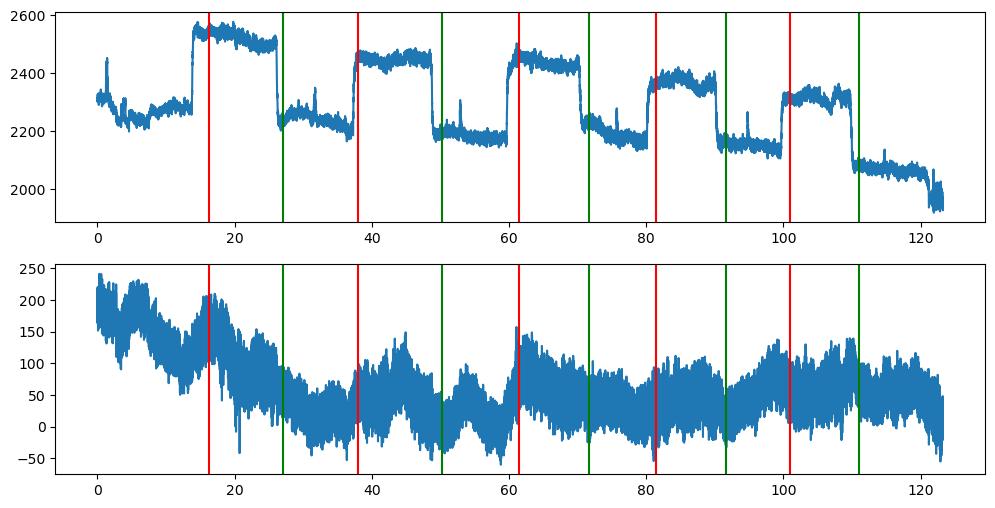

In [3]:
fig, ax = plt.subplots(2,1, figsize=(12,6))

t = np.arange(eeg_data.shape[0])/fs # Time axis data starts at time 0 and goes to the end with 1/sampling-rate time steps

ax[0].plot(t, eeg_data[:,0]) # Plot channel 0 (Fp1)
ax[1].plot(t, eeg_data[:,13]) # Plot channel 13 (O1)

# Plot the moments when the eyes closed and the eyes opened according to the experimenter
for a in ax:
    for closed in eyes_closed_indices:
        a.axvline(t[closed], color='r')
    for opened in eyes_opened_indices:
        a.axvline(t[opened], color='g')        

We immediately notice a few things here. 

First, there is a large artifact when the eyes are opened and closed. The artifact is larger in the channel near the eyes and smaller in the channel on the back of the head.

Second, the experimenter coding of when the eyes are closed and opened is slightly offset from when it happens in the experiment. We won't worry about this, but an Extra Credit problem below asks you to correct for it and repeat the analyses.

What does the data look like if we zoom in around the eye closing period? Looking at the indices, it seems like the timing is better for the second event - let's use that one to plot

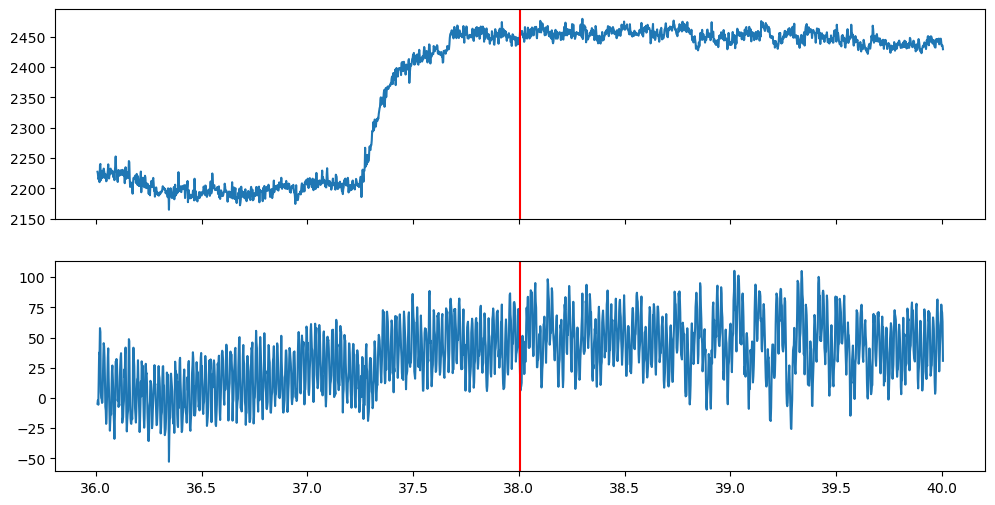

In [4]:
closed_index = eyes_closed_indices[1,0] # Index of second eyes closing index

fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)

ax[0].plot(t[closed_index - 1024: closed_index + 1024], eeg_data[closed_index - 1024: closed_index + 1024, 0])
ax[1].plot(t[closed_index - 1024: closed_index + 1024], eeg_data[closed_index - 1024: closed_index + 1024, 13])
ax[0].axvline(t[closed_index], color='r')
ax[1].axvline(t[closed_index], color='r')

## Problem 1: Looking at data in frequency domain.

Let's begin by asking a question. What channel has the highest change in power in the alpha band during the eyes-closed state? In order to answer this question, we will extract the signal during the eyes closed and eye open periods. The experimenters specify that these periods last 10s, but we've already seen that the onset/offsets are pretty noisy (maybe 1-4 seconds after the actual event. So let's extract 4-second windows of signal starting 4 seconds after each cue.

In [5]:
eyes_closed_signals = []
eyes_opened_signals = []
window_indices = np.arange(4*fs) + 4*fs # Indices will be a vector of 4 s of samples start 4 s after index

for closed in eyes_closed_indices:
    eyes_closed_signals.append(eeg_data[closed + window_indices,:])

for opened in eyes_opened_indices:
    eyes_opened_signals.append(eeg_data[opened + window_indices,:])



Now, let's calculate "Power Spectral Density" for each of these little windows for channel 0 and channel 1. 

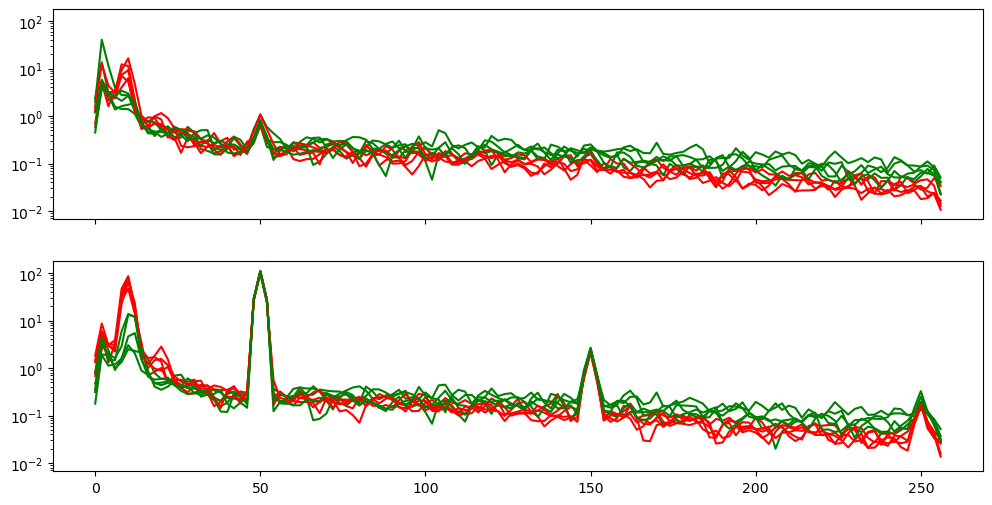

In [6]:
fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True, sharey=True)

for i in range(5):
    # Calculate and plot the PSDs for channel 0
    f, Pxx = signal.welch(eyes_closed_signals[i][:,0], fs, nperseg=256)
    ax[0].semilogy(f,Pxx, 'r')
    f, Pxx = signal.welch(eyes_opened_signals[i][:,0], fs, nperseg=256)
    ax[0].semilogy(f,Pxx, 'g')

    # Calculate and plot the PSDs for channel 13
    f, Pxx = signal.welch(eyes_closed_signals[i][:,13], fs, nperseg=256)
    ax[1].semilogy(f,Pxx, 'r')
    f, Pxx = signal.welch(eyes_opened_signals[i][:,13], fs, nperseg=256)
    ax[1].semilogy(f,Pxx, 'g')


In order to answer our question, we have to decide what frequency band alpha should be. Let's zoom in our our spectra in the relevant range. 

/var/folders/tp/mjl42hmn7cdcyjqb756_160h0000gn/T/ipykernel_60026/832643232.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1,1].legend()


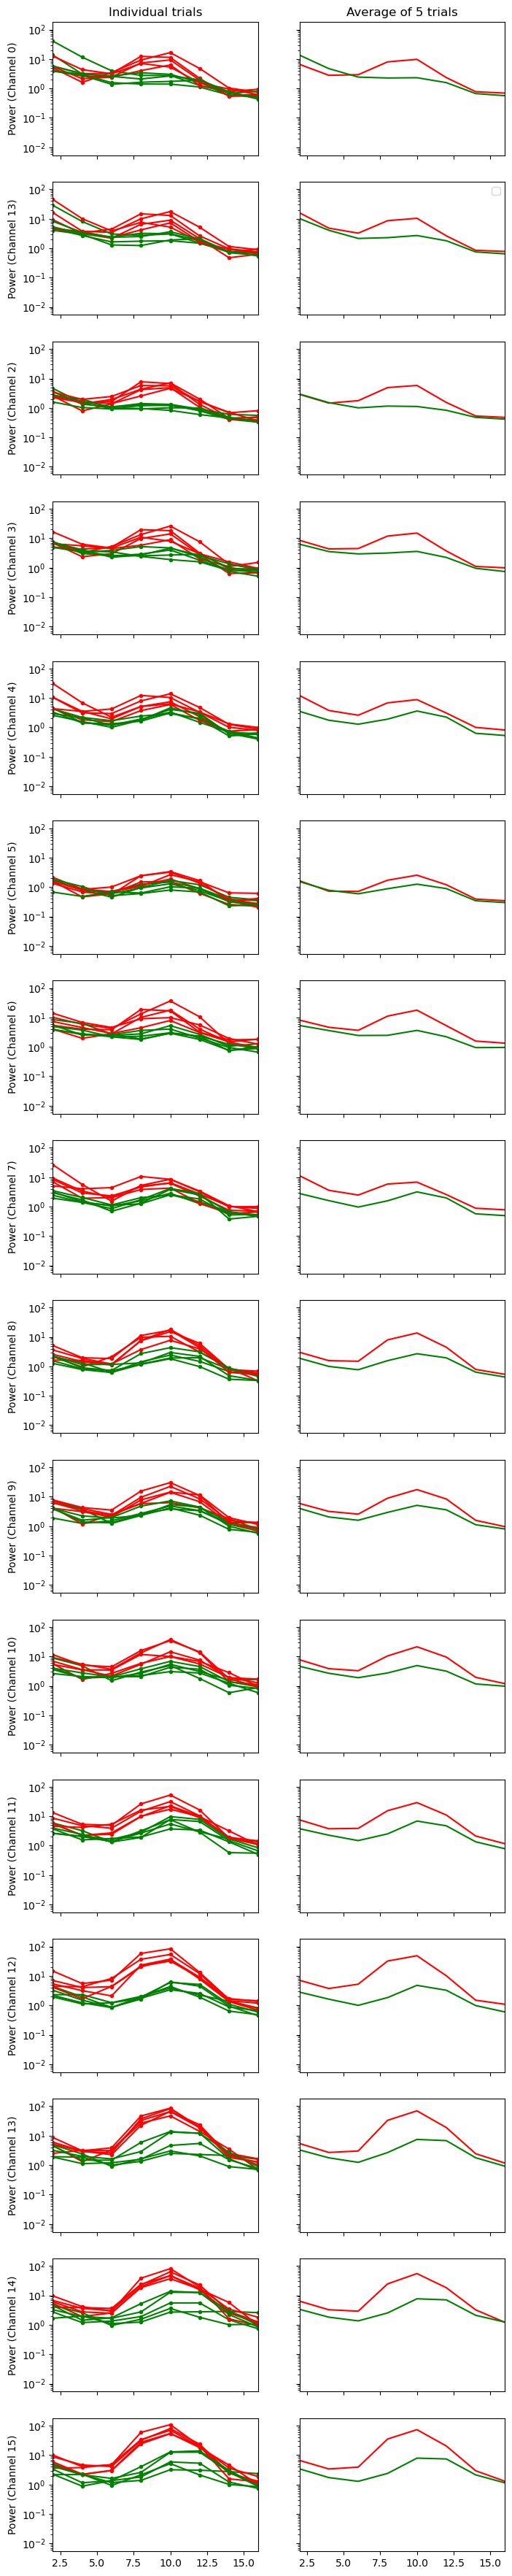

In [7]:
fig, ax = plt.subplots(16,2, figsize=(8,45), sharex=True, sharey=True)

nperseg = 256

for ch in range(16):

    eyes_closed_Pxx = []
    eyes_opened_Pxx = []
    # Calculate and plot the PSDs for channel 0
    for i in range(5):
        f, Pxx = signal.welch(eyes_closed_signals[i][:,ch], fs, nperseg=nperseg)
        ax[ch,0].plot(f,Pxx, 'r.-')
        eyes_closed_Pxx.append(Pxx)
        f, Pxx = signal.welch(eyes_opened_signals[i][:,ch], fs, nperseg=nperseg)
        ax[ch,0].plot(f,Pxx, 'g.-')
        eyes_opened_Pxx.append(Pxx)
        
    ax[ch,1].semilogy(f, np.mean(eyes_closed_Pxx, axis=0), 'r')
    ax[ch,1].semilogy(f, np.mean(eyes_opened_Pxx, axis=0), 'g')
    ax[ch,0].set_ylabel('Power (Channel {})'.format(ch))


# eyes_closed_Pxx = []
# eyes_opened_Pxx = []
# # Calculate and plot the PSDs for channel 13
# for i in range(5):
#     f, Pxx = signal.welch(eyes_closed_signals[i][:,13], fs, nperseg=nperseg)
#     eyes_closed_Pxx.append(Pxx)
#     ax[1,0].plot(f,Pxx, 'r.-')

#     f, Pxx = signal.welch(eyes_opened_signals[i][:,13], fs, nperseg=nperseg)
#     eyes_opened_Pxx.append(Pxx)
#     ax[1,0].plot(f,Pxx, 'g.-')

# ax[1,1].plot(f, np.mean(eyes_closed_Pxx, axis=0), 'r', label='Eyes Closed')
# ax[1,1].plot(f, np.mean(eyes_opened_Pxx, axis=0), 'g', label='Eyes Opened')

ax[0,0].set_title('Individual trials')
ax[0,1].set_title('Average of 5 trials')
ax[1,0].set_ylabel('Power (Channel 13)')
ax[0,0].set_xlim(2,16)
ax[1,1].legend()


## Problem 1A: What frequency is the alpha rhythm for this subject?

Recall that naively using the Fourier transform on the data will result in frequency estimates that may be noisy. The Welch PSD method averages the results of smaller, overlapping windows (with size set by the `nperseg` parameter. This results in less noisy estimates, but lower frequency resolution (shorter window <-> lower frequency resolution).  Try different values of the `nperseg` parameter and see if that changes your answer.

## Problem 1B: What channel shows the largest average alpha signal when eyes are closed? Which shows the largest difference between eyes opened and eyes closed?

Below, we have sample code which integrates the cells above to calculate the average alpha signal for a given `nperseg` value and given `frequency` corresponding to what you decide is the frequency that you want to test at, and the `eeg_channel` you want to look at. Use (or modify) this code in order to extract the values for all the channels so that you can calculate which channel(s) have the largest closed-eye alpha signal and which have the largest ratio of eyes-closed to eyes-open alpha signal.

Coding suggestion - make a loop through the channels. For each channel extract both the eyes-closed alpha power and the ratio of powers. An example of how to plot the result once you've calculated it is below...

In [8]:
def extract_alpha_power(eeg_channel=0, frequency=6, nperseg=256, window_size=4.0, window_offset=4.0):
    eyes_closed_signals = []
    eyes_opened_signals = []
    window_indices = np.arange(int(window_size*fs)) + int(window_offset*fs) # this is the index into the data for the time windows
    
    for closed in eyes_closed_indices:
        eyes_closed_signals.append(eeg_data[closed + window_indices,:])
    
    for opened in eyes_opened_indices:
        eyes_opened_signals.append(eeg_data[opened + window_indices,:])

    f, eyes_closed_Pxx = signal.welch(eyes_closed_signals, fs, axis=1, nperseg=nperseg) # axis 0 is trials, axis 1 is time, axis 2 is channel
    f, eyes_opened_Pxx = signal.welch(eyes_opened_signals, fs, axis=1, nperseg=nperseg)

    fidx = np.abs(f - frequency).argmin()
    print('Using frequency {} ({} specified).'.format(f[fidx], frequency))
    
    return np.mean(eyes_closed_Pxx[:,fidx,eeg_channel], axis=0), np.mean(eyes_opened_Pxx[:,fidx,eeg_channel], axis=0)


# Example data point
eyes_closed_power, eyes_opened_power = extract_alpha_power(eeg_channel=13, frequency=6.9)
print(eyes_closed_power)


Using frequency 6.0 (6.9 specified).
3.0147589249743945


In [9]:
alpha_power = []
alpha_power_ratio = []
for ch in range(16):
    ####
    # Fill in function call, ratio calculation and list appends (i.e., alpha_power.append(value1)) here...
    ###

# Plotting code
fig, ax = plt.subplots(1,2, figsize=(18,4))
plot_labels = ['{} ({})'.format(ind, lab) for lab, ind in enumerate(channel_labels)]
ax[0].bar(plot_labels, alpha_power)
ax[0].tick_params(axis='x', labelrotation=90)
ax[0].set_title('Alpha Power (Eyes Closed)')
ax[1].bar(plot_labels, alpha_power_ratio)
ax[1].tick_params(axis='x', labelrotation=90)
ax[1].set_title('Alpha Power Ratio')

IndentationError: expected an indented block after 'for' statement on line 3 (4272268467.py, line 9)

## Problem 1C: Which channel has the most noise?

Which channel has the most line noise (which is at 50 Hz in France!)? (You can use similar windows as before, though note that the line noise shouldn't be different with eyes open and eyes closed. Alternatively, look for the whole session.)


# Problem 2: Calculating a Fourier-Based Spectrum

The "Short Term Fourier Transform" is the technical term for the standard Fourier Transform based spectrogram. In order to avoid the issues that come from sharp window boundaries, the STFT uses windows with rounded edges. In the example code below, we use one of the standard windows, the "Hamming Window". Other common choices include Gaussians, Trianglular Windows, Hann windows and others. As we discussed in class, the choice of the window length (`Nx` in the `get_window()` call below) directly affects time/frequency resolution - longer windows will have better resolution in frequency, and worse resolution in time. The `hop` parameter in the STFT initialization specifies how the window is slid along the data. Making `hop` smaller will result in more computation time, but potentially better temporal resolution (keeping in mind the window size also affects that!).

The code below calculates and then plots the spectrogram for channel 0 in our data. The choice of `Nx=2048` chooses for high resolution in frequency. 

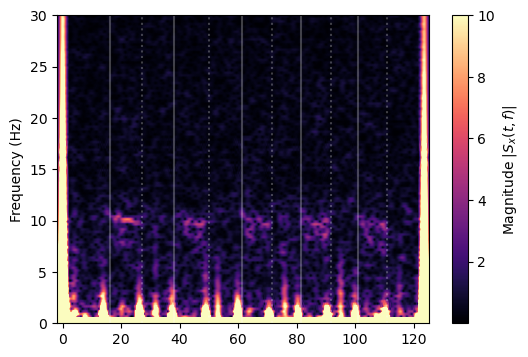

In [10]:
hamm_win = signal.get_window('hamming', Nx=2048);
SFT = signal.ShortTimeFFT(hamm_win, hop=32, fs=fs, scale_to='psd') # 'psd` scaling affects how signal is normalized across frequency
stft = SFT.stft(eeg_data, axis=0)

fig, ax = plt.subplots(1,1,figsize=(6,4))
im = ax.imshow((abs(stft[:,0,:])), origin='lower', aspect='auto',
                 extent=SFT.extent(eeg_data.shape[0]), cmap='magma', vmax=10)
fig.colorbar(im, label="Magnitude $|S_x(t, f)|$")
ax.set_ylabel('Frequency (Hz)')
ax.set_ylim(0, 30)
[ax.axvline(t_eeg[idx], color='white', alpha=0.25) for idx in eyes_closed_indices]
[ax.axvline(t_eeg[idx], linestyle=':', color='white', alpha=0.25) for idx in eyes_opened_indices]

## Problem 2A: Spectrogram of Alpha
Using the channel that you settled on as "best" for Probem 1, plot the spectrogram of alpha during eyes closing and opening. Play around with the `Nx=2048` parameter selection to see how this affects the spectrogam (_not graded_).

## Problem 2B: Does the frequency of Alpha sweep?
In this subject, it seems like the frequency of the Alpha rhythm sweeps downward slightly following eye closing. Load and plot a spectrogram for a good channel from Subjects 8 and 12. Do you see the same phenomenon in these subjects?



# Problem 3: Linear Filters
When we observe our power spectra, one of the obvious factors is that there is lots of spectral energy at frequencys other than the alpha band. Let's design a linear filter to isolate the alpha signal in our EEG data. The `firls()` function designs a filter (using "Least Squares"). The parameters of the function describe what we want from it in terms of frequency. `[5, 7, 12, 14]` and `[0, 1, 1, 0]` describes that we want no signal at frequencies below 5 Hz, full signal between 7 and 12 Hz, and no signal again above 14 Hz. The `numtaps` parameter describes how long the filter should be. For this kind of filter, the number should be odd. I've initially chosen this to be 33, which is approximately one cycle of a 8 Hz signal with FS=512 Hz, but you will explore the effects of longer filters.

In [11]:
b = signal.firls(numtaps=33, bands=[0, 5, 7, 12, 14, 256], desired=[0, 0, 1, 1, 0, 0], fs=fs)

We can visualize how well a filter will work using the `freqz()` function. 

Text(0, 0.5, 'Response of filter (dB)')

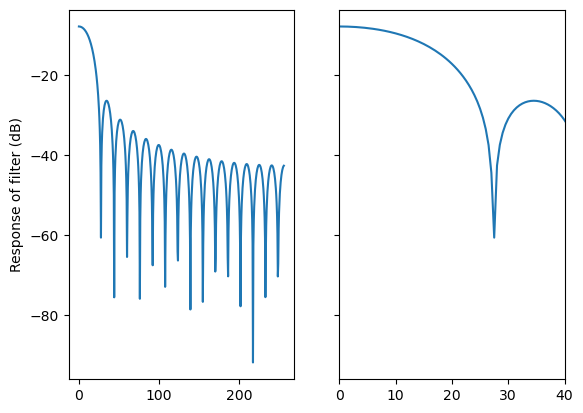

In [12]:
f, response = signal.freqz(b, fs=fs) # Filter response is a complex number. We can ignore the phase for now.

fig, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(f, 20*np.log10(np.abs(response))) # 20*log10() creates a response in "dB"
ax[1].plot(f, 20*np.log10(np.abs(response)))
ax[1].set_xlim(0,40)
ax[0].set_ylabel('Response of filter (dB)')

The filter we've designed blocks frequences pretty well above ~20 Hz, but it doesn't seem to be doing a great job at lower frequencies. Let's make it a bit longer - `numtaps=65` instead of 33.

Text(0, 0.5, 'Response of filter (dB)')

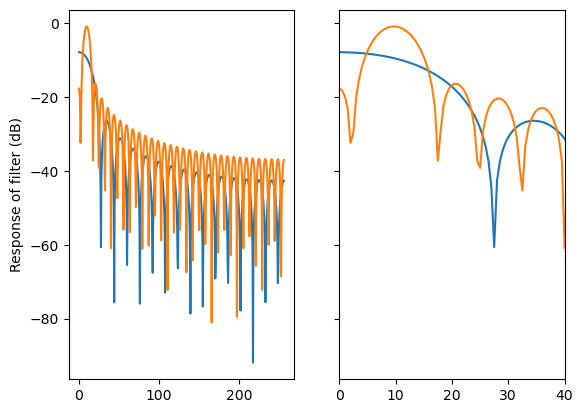

In [13]:
b2 = signal.firls(numtaps=65, bands=[0, 5, 7, 12, 14, 256], desired=[0, 0, 1, 1, 0, 0], fs=fs)
f, response2 = signal.freqz(b2, fs=fs) # Filter response is a complex number. We can ignore the phase for now.

fig, ax = plt.subplots(1,2, sharey=True)
ax[0].plot(f, 20*np.log10(np.abs(response))) # 20*log10() creates a response in "dB"
ax[0].plot(f, 20*np.log10(np.abs(response2))) # 20*log10() creates a response in "dB"
ax[1].plot(f, 20*np.log10(np.abs(response)))
ax[1].plot(f, 20*np.log10(np.abs(response2)))
ax[1].set_xlim(0,40)
ax[0].set_ylabel('Response of filter (dB)')

Our new filter is isolating both high and low frequencies. Now, let us apply it to our EEG data. In general, when you are filtering, you should use the function `filtfilt()`. This slides the filter along the signal forward in time _and_ backward in time. The result is that signals will be smeared in time symmetrically forward and backward, as we are going to explore.

In [14]:
alpha_data = signal.filtfilt(b2, 1, eeg_data, axis=0)

Now let's look at the result in the time domain. We'll plot the same segment of signal on Channels 0 and 13 as we did up above, but this time also the alpha band signal.


Text(0, 0.5, 'Channel 13 Signal')

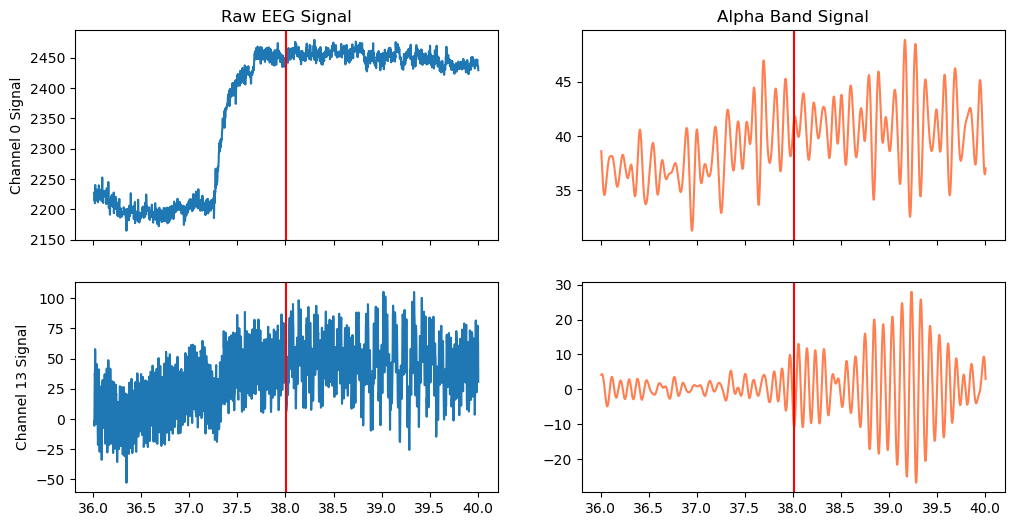

In [15]:
closed_index = eyes_closed_indices[1,0] # Index of second eyes closing index

fig, ax = plt.subplots(2,2, figsize=(12,6), sharex=True)

ax[0,0].plot(t[closed_index - 1024: closed_index + 1024], eeg_data[closed_index - 1024: closed_index + 1024, 0])
ax[1,0].plot(t[closed_index - 1024: closed_index + 1024], eeg_data[closed_index - 1024: closed_index + 1024, 13])

ax[0,1].plot(t[closed_index - 1024: closed_index + 1024], alpha_data[closed_index - 1024: closed_index + 1024, 0], color='coral')
ax[1,1].plot(t[closed_index - 1024: closed_index + 1024], alpha_data[closed_index - 1024: closed_index + 1024, 13], color='coral')

[a.axvline(t[closed_index], color='r') for a in ax.flatten()]

ax[0,0].set_title('Raw EEG Signal')
ax[0,1].set_title('Alpha Band Signal')
ax[0,0].set_ylabel('Channel 0 Signal')
ax[1,0].set_ylabel('Channel 13 Signal')

What about the spectrograms? Let's see how filtering changes them.

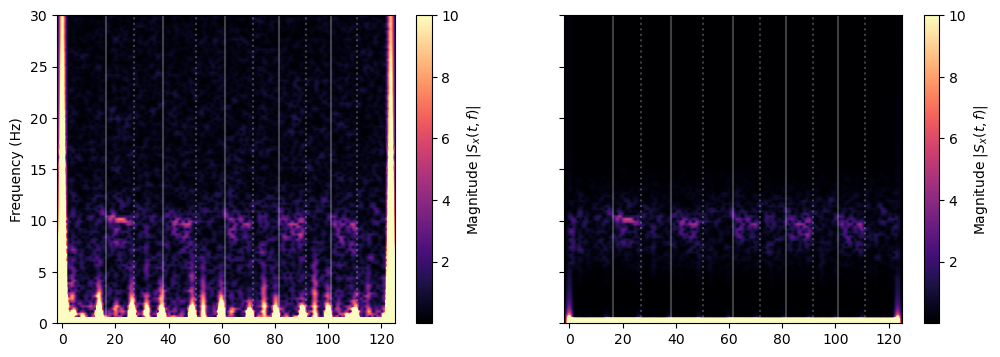

In [26]:
hamm_win = signal.get_window('hamming', Nx=2048);
SFT = signal.ShortTimeFFT(hamm_win, hop=32, fs=fs, scale_to='psd') # 'psd` scaling affects how signal is normalized across frequency
stft = SFT.stft(eeg_data, axis=0)

fig, axs = plt.subplots(1,2,figsize=(12,4), sharey=True, sharex=True)
im = axs[0].imshow((abs(stft[:,0,:])), origin='lower', aspect='auto',
                 extent=SFT.extent(eeg_data.shape[0]), cmap='magma', vmax=10)
fig.colorbar(im, label="Magnitude $|S_x(t, f)|$")
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_ylim(0, 30)

stft2 = SFT.stft(alpha_data, axis=0)
im2 = axs[1].imshow((abs(stft2[:,0,:])), origin='lower', aspect='auto',
                 extent=SFT.extent(eeg_data.shape[0]), cmap='magma', vmax=10)
fig.colorbar(im2, label="Magnitude $|S_x(t, f)|$")


for ax in axs:
    [ax.axvline(t_eeg[idx], color='white', alpha=0.25) for idx in eyes_closed_indices]
    [ax.axvline(t_eeg[idx], linestyle=':', color='white', alpha=0.25) for idx in eyes_opened_indices]

It looks like most of the non-alpha signal is gone, but at the lowest frequencies there still is power. Looking back at the time domain signal, we see that at time 38.0, channel 0 is quite far from 0 (unlike channel 13). Frequency 0 in a power spectrum/spectrogram is equal to the mean of the signal, so when it's nonzero, that means the mean is still far from zero.

### What about temporal smearing?

Let's construct a fake signal and filter it in order to highlight temporal smearing. Let's make a 1 s long pulse of alpha in the middle of a 5 s period of absolute silence.

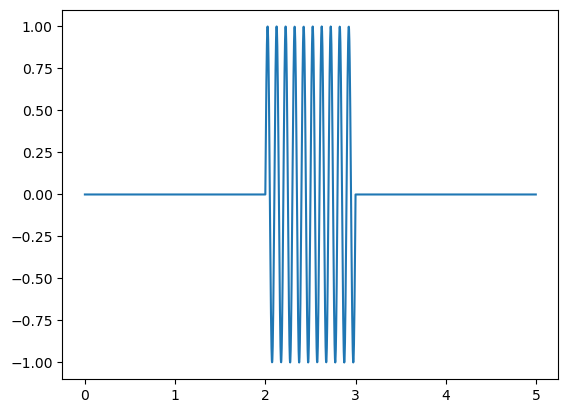

In [28]:
fake_t = np.arange(5*fs)/fs
fake_alpha = np.zeros(fake_t.shape[0])
fake_alpha[2*fs:3*fs] = np.sin(2*np.pi*10*fake_t[2*fs:3*fs])
plt.plot(fake_t, fake_alpha)

## Problem 3a: Filter smearing

Filter the fake alpha signal with the two filters we created above (`b` and `b2`) using `filtfilt()`, and plot it. 

  - How far does the filtered alpha signal extend beyond its original bounds? (in cycles)
  - Do you notice any distortion in the shape of the output signal?


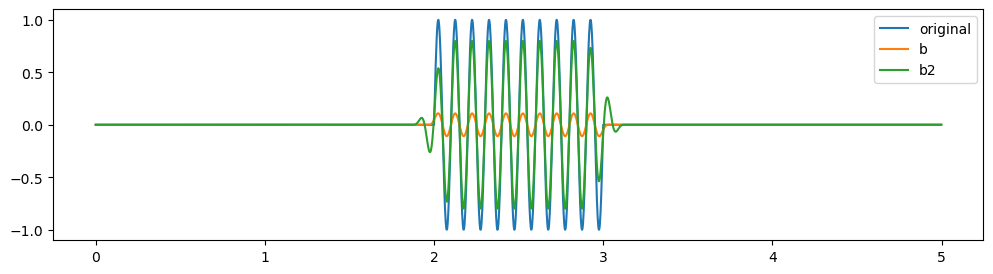

In [29]:
fig, ax = plt.subplots(1,1, figsize=(12,3))
ax.plot(fake_t, fake_alpha, label='original')

###
# Generate filtered versions of fake alpha and plot them
###

ax.legend()




## Problem 3b: Filter design and smearing

Now design a new filter with `numtaps=513` and answer the questions above. In particular, where do you notice the most signal distortion?


## ELEC 587 Required Problem 4 (EC for others):  Quantifying Alpha Sweep
Using the Fp channels,  re-align the eye closing epochs to start when the eyes muscle artifact actually indicates the eye closed. Extract each eye closing event using filtered Alpha data and calculate the average alpha spectrogram in response to eye closing. Extract the maximum frequency at each time point. If you combine the 5 observations from Subjects 6, 8, and 12, for each time point you should have 15 samples. Fit a linear regression to these samples and report the statistical signficance of its slope.

# Wavelet spectrogram (for edification)

Below is some sample code using the `ghostipy` package from Rice. You'll need to `pip install ghostipy` in order to access it. (`!pip install ghostipy` if you're using Google Colab). One of the things the wavelet spectrogram makes clear (and is also apparent in the filtered time series) is that our alpha actually occurs in pulses, as opposed to as a continuous oscillation.

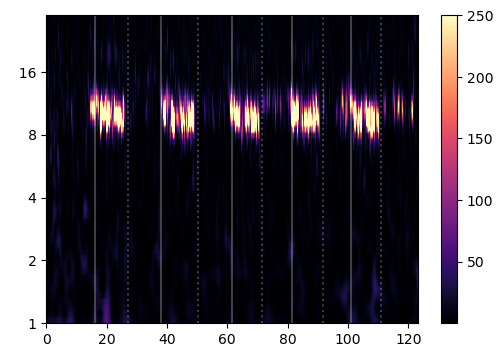

In [32]:
import ghostipy as gsp

fs_eeg = 512

gamma = 3 
beta = 25 # decrease beta to improve temporal resolution, increase to increase frequency resolution

cwtcoefs, _, freq, cwtts, _ = gsp.cwt(
    eeg_data[:,13], freq_limits=[1, 30], fs=fs_eeg,
    wavelet=gsp.MorseWavelet(gamma=gamma, beta=beta))

cwt_power = cwtcoefs.imag**2 + cwtcoefs.real**2

t_eeg = np.arange(0, eeg_data.shape[0])/fs
ff = np.flipud(freq)

# Wavelets sample across logarithmically spaced frequencies. To display these nicely

@plt.FuncFormatter
def fake_log(x, pos):
    df = (np.log(ff[-1]) - np.log(ff[0]))/(len(ff) - 1)
    f = np.exp(df*x + np.log(ff[0]))
    return '{:4.0f}'.format(f)

def inv_fake_log(f):
    df = (np.log(ff[-1]) - np.log(ff[0]))/(len(ff) - 1)
    x = (np.log(f) - np.log(ff[0]))/df 
    return x


fig, ax = plt.subplots(1,1, figsize=(6,4))
im = ax.imshow(cwt_power, interpolation=None, aspect='auto',
               extent=[t_eeg[0], t_eeg[-1],0,len(freq)-1],
               cmap=plt.cm.magma, vmax=250)
ax.yaxis.set_major_formatter(fake_log)
# ax.set_yticks(inv_fake_log([1, 2, 4, 8, 16, 32]))
plt.colorbar(im)
[ax.axvline(t_eeg[idx], color='white', alpha=0.25) for idx in eyes_closed_indices];
[ax.axvline(t_eeg[idx], linestyle=':', color='white', alpha=0.25) for idx in eyes_opened_indices];